In [1]:
import numpy as np
import pandas as pd
import cv2
import ast
from tqdm import tqdm
from PIL import Image, ImageDraw
import pickle
from CRAFT import CRAFTModel, draw_boxes, draw_polygons, boxes_area, polygons_area

/home/nguyenhao/miniconda3/envs/nguyenhao/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [69]:
model = CRAFTModel('cuda', use_refiner=True, fp16=True)

/home/nguyenhao/miniconda3/envs/mc_ocr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nguyenhao/miniconda3/envs/mc_ocr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/nguyenhao/Source/MC_OCR/MC_OCR/Documentation/Text_Detection/CRAFT_Text_Detection/CRAFT/craft.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models fo

# Các giá trị config ban đầu

In [2]:
dataset_path = '../../../dataset/mcocr_train_df.csv'
train_img_path = '../../../dataset/train_images'

In [4]:
# Đọc dữ liệu
df = pd.read_csv(dataset_path)
df.head()

,img_id,anno_polygons,anno_texts,anno_labels,anno_num,anno_image_quality
0,mcocr_public_145013ddcph.jpg,"[{'category_id': 15, 'segmentation': [[231.9, ...",MINIMART ANAN|||Chợ Sủi Phú Thị Gia Lâm|||Ngày...,SELLER|||ADDRESS|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.635309
1,mcocr_public_145013fxcgs.jpg,"[{'category_id': 15, 'segmentation': [[311.6, ...",VinCommerce|||VM + QNH Dự án quỹ đất đường sắt...,SELLER|||ADDRESS|||ADDRESS|||ADDRESS|||TIMESTA...,7,0.774317
2,mcocr_public_145013clltn.jpg,"[{'category_id': 15, 'segmentation': [[626.8, ...",SIEU THI BACH HOA TONG HOP|||Bố 5 Cẩm Tây - Cẩ...,SELLER|||ADDRESS|||TOTAL_COST|||TOTAL_COST|||T...,5,0.664084
3,mcocr_public_145013tmibr.jpg,"[{'category_id': 15, 'segmentation': [[715.5, ...",co.op mart|||Co.opMart HAU GIANG|||188 Hau Gia...,SELLER|||SELLER|||ADDRESS|||ADDRESS|||TIMESTAM...,8,0.715504
4,mcocr_public_145013kgypr.jpg,"[{'category_id': 16, 'segmentation': [[200.5, ...","Tổ 7, Khu Minh Tiến A|||VinCommerce|||Ngày bán...",ADDRESS|||SELLER|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.766884


In [5]:
# Tính toán IoU 
'''
Tính các giá trị iou giữa các box được cho trong dataframe trên và các box mà CRAFT tạo ra. Nêu giá trị IoU lớn hơn 0.1
thì giữ nguyên các box mà BTC đã label sẵn. Ngược lại nếu nhỏ hơn thì đưa các box đó vào lớp OTHER.
'''
def iou(bbox1: list, bbox2: list) ->float:
    x11, y11, x12, y12 = bbox1
    x21, y21, x22, y22 = bbox2

    area1 = (x12 - x11) * (y12 - y11)
    area2 = (x22 - x21) * (y22 -  y21)

    intersection_width = min(x12, x22) - max(x11, x21)
    intersection_height = min(y12, y22) - max(y11, y21)
    
    if intersection_width <= 0 or intersection_height <= 0:
        return 0

    intersection = intersection_width * intersection_height
    union = area1 + area2 - intersection
    iou = intersection/union 
    return  iou if iou > 0 else 0

## Test
bbox1 = [123, 56, 150, 67]
bbox2 = [123, 56, 150, 67]
print(iou(bbox1, bbox2))

1.0


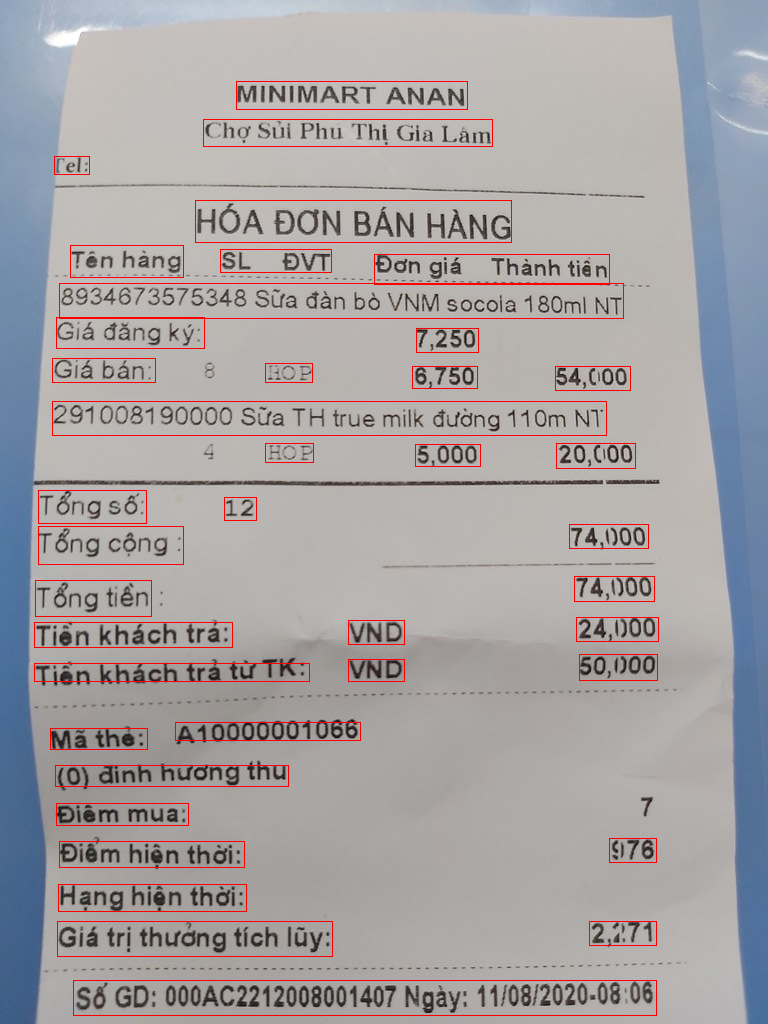

In [6]:
# Test CRAFT
import os
img_name = 'mcocr_public_145013ddcph.jpg'
img = Image.open(os.path.join(train_img_path, img_name))
boxes = model.get_boxes(img)


draw = ImageDraw.Draw(img)
for box in boxes:
    draw.rectangle((box[0][0], box[0][1],box[2][0], box[2][1]), outline='red')
img.show() 


In [7]:
other_class =[]
for i, img_name in enumerate(df['img_id']):
    img_path = os.path.join(train_img_path, img_name)
    img = Image.open(img_path)
    #  Gọi model CRAF
    boxes = model.get_boxes(img)
    annotation_image = {
        'img_name': img_name,
        'bbox':[]
    }
    for box in boxes:
        x1, y1, x2, y2 = box[0][0], box[0][1], box[2][0], box[2][1]
        bbox1 = [x1, y1, x2, y2]
        check = False
        for element in ast.literal_eval(df['anno_polygons'][i]):
            x, y, w, h = element['bbox']
            x1, y1, x2, y2 = x, y, x + w, y + h
            bbox2 = [x1, y1, x2, y2]
            if iou(bbox1,  bbox2) > 0.1:
                check = True
                break

        if check == False:
            annotation_image['bbox'].append(bbox1)
    other_class.append(annotation_image)


In [8]:
other_class

[{'img_name': 'mcocr_public_145013ddcph.jpg',
  'bbox': [[54, 156, 89, 174],
   [195, 200, 511, 242],
   [70, 245, 183, 277],
   [220, 249, 331, 272],
   [374, 254, 609, 284],
   [59, 283, 623, 318],
   [56, 317, 204, 348],
   [416, 328, 478, 352],
   [52, 358, 155, 382],
   [265, 363, 312, 382],
   [412, 366, 477, 388],
   [555, 366, 630, 390],
   [52, 401, 606, 435],
   [265, 443, 313, 462],
   [415, 444, 480, 466],
   [556, 443, 635, 468],
   [38, 490, 146, 523],
   [224, 497, 256, 520],
   [569, 524, 648, 548],
   [38, 526, 183, 564],
   [576, 617, 658, 641],
   [34, 622, 232, 647],
   [348, 620, 404, 644],
   [579, 654, 657, 680],
   [34, 663, 309, 681],
   [348, 659, 404, 681],
   [175, 722, 360, 740],
   [50, 728, 147, 749],
   [55, 765, 288, 786],
   [56, 803, 188, 825],
   [609, 838, 656, 862],
   [59, 841, 244, 867],
   [58, 884, 246, 911],
   [589, 921, 656, 945],
   [57, 921, 332, 956]]},
 {'img_name': 'mcocr_public_145013fxcgs.jpg',
  'bbox': [[384, 267, 516, 291],
   [304

In [9]:
with open('box_of_other_class.pkl', 'wb') as f:
    pickle.dump(other_class, f)

In [10]:
#  Kiểm tra lại class other 
img = Image.open(os.path.join(train_img_path, 'mcocr_public_145013ddcph.jpg'))

draw = ImageDraw.Draw(img)
for box in other_class[0]['bbox']:
    x1, y1, x2, y2 = box
    draw.rectangle((x1, y1, x2, y2), outline='red')

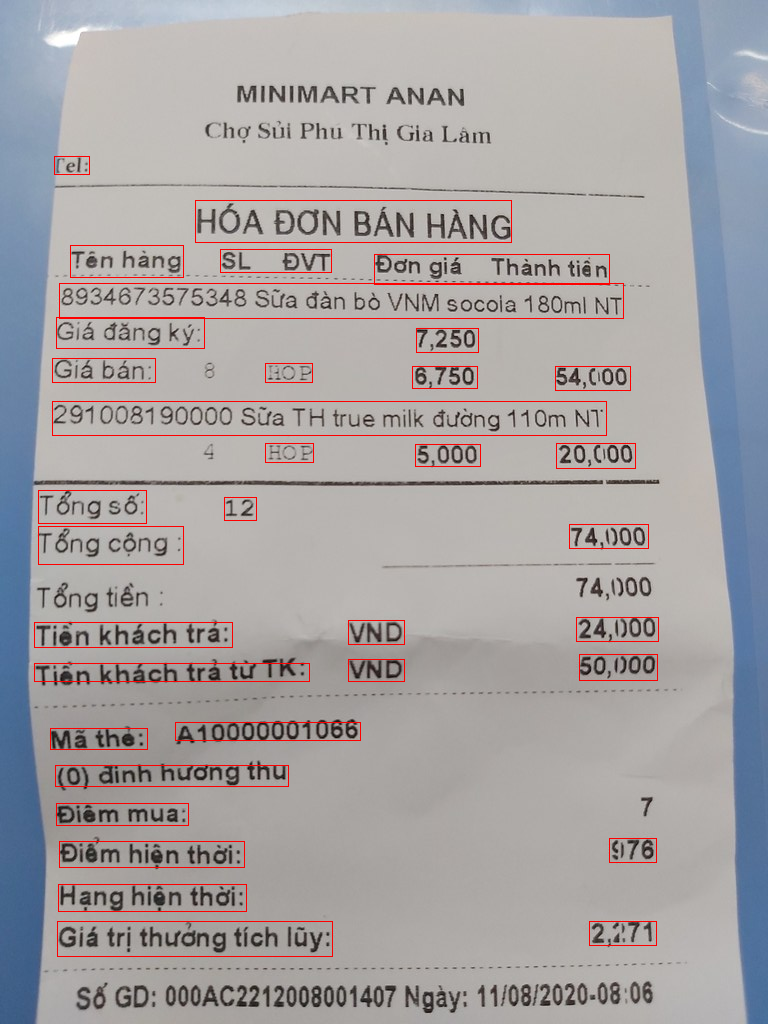

In [11]:
img.show()

In [29]:
'''
Sử dụng tập dữ liệu trong dataframe được cho để thành trước 
4 lớp bao gồm SELLER, ADDRESS, TIMESTAMP, TOTAL_COST
'''
df = pd.read_csv(dataset_path)
df.head()


,img_id,anno_polygons,anno_texts,anno_labels,anno_num,anno_image_quality
0,mcocr_public_145013ddcph.jpg,"[{'category_id': 15, 'segmentation': [[231.9, ...",MINIMART ANAN|||Chợ Sủi Phú Thị Gia Lâm|||Ngày...,SELLER|||ADDRESS|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.635309
1,mcocr_public_145013fxcgs.jpg,"[{'category_id': 15, 'segmentation': [[311.6, ...",VinCommerce|||VM + QNH Dự án quỹ đất đường sắt...,SELLER|||ADDRESS|||ADDRESS|||ADDRESS|||TIMESTA...,7,0.774317
2,mcocr_public_145013clltn.jpg,"[{'category_id': 15, 'segmentation': [[626.8, ...",SIEU THI BACH HOA TONG HOP|||Bố 5 Cẩm Tây - Cẩ...,SELLER|||ADDRESS|||TOTAL_COST|||TOTAL_COST|||T...,5,0.664084
3,mcocr_public_145013tmibr.jpg,"[{'category_id': 15, 'segmentation': [[715.5, ...",co.op mart|||Co.opMart HAU GIANG|||188 Hau Gia...,SELLER|||SELLER|||ADDRESS|||ADDRESS|||TIMESTAM...,8,0.715504
4,mcocr_public_145013kgypr.jpg,"[{'category_id': 16, 'segmentation': [[200.5, ...","Tổ 7, Khu Minh Tiến A|||VinCommerce|||Ngày bán...",ADDRESS|||SELLER|||TIMESTAMP|||TOTAL_COST|||TO...,5,0.766884


In [30]:
label = df['anno_labels'][0].split('|||')
print(label)
text = df['anno_texts'][0].split('|||')
print(text)



['SELLER', 'ADDRESS', 'TIMESTAMP', 'TOTAL_COST', 'TOTAL_COST']
['MINIMART ANAN', 'Chợ Sủi Phú Thị Gia Lâm', 'Ngày : 11/08/2020 08:06', 'Tổng tiền:', '74,000']


In [39]:
SELLER = []
ADDRESSS = []
TIMESTAMP = []
TOTAL_COST = []

for i, anno_labels in enumerate(df['anno_labels']):
    if type(anno_labels) == float:
        continue
    anno_labels = anno_labels.split('|||')
    anno_text = df['anno_texts'][i].split('|||')
    for index, label in enumerate(anno_labels):
        if label == 'SELLER':
            SELLER.append(anno_text[index])
        elif label == 'ADDRESS':
            ADDRESSS.append(anno_text[index])
        elif label == 'TIMESTAMP':
            TIMESTAMP.append(anno_text[index])
        elif label == 'TOTAL_COST':
            TOTAL_COST.append(anno_text[index])


            



In [41]:
print(SELLER[:5])
print(ADDRESSS[:5])
print(TIMESTAMP[:5])
print(TOTAL_COST[:5])

['MINIMART ANAN', 'VinCommerce', 'SIEU THI BACH HOA TONG HOP', 'co.op mart', 'Co.opMart HAU GIANG']
['Chợ Sủi Phú Thị Gia Lâm', 'VM + QNH Dự án quỹ đất đường sắt', 'DA QĐ doc tuyến ĐS Tổ 3 Khu 2', 'P.Cẩm Sơn, TP.Cẩm Phả, T.QN', 'Bố 5 Cẩm Tây - Cẩm Phả - QN']
['Ngày : 11/08/2020 08:06', 'Ngày bán: 15/08/2020 11:41', 'Ngày: 21/05/2020', '20 : 42 : 52', 'Ngày bán: 14/08/2020 20:00']
['Tổng tiền:', '74,000', 'TỔNG TIỀN PHẢI T.TOÁN', '30.900', '72.000']


In [42]:
with open('SELER_class.pkl', 'wb') as f:
    pickle.dump(SELLER, f)

with open('ADDRESSS_class.pkl', 'wb') as f:
    pickle.dump(ADDRESSS, f)

with open('TIMESTAMP_class.pkl', 'wb') as f:
    pickle.dump(TIMESTAMP, f)

with open('TOTAL_COST_class.pkl', 'wb') as f:
    pickle.dump(TOTAL_COST, f)

In [3]:
'''
Sử dụng thư viện VietOCR để tạo ra class Other cho mô hình phân loại
text
'''
# Import các thư viện cần thiết

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [4]:
config = Cfg.load_config_from_name('vgg_transformer')
config['weights'] = '../../Text_Recognize/weights/transformerocr.pth'
config['cnn']['pretrained'] = False
config['device'] = 'cuda:0'

In [5]:
detector = Predictor(config)

/home/nguyenhao/miniconda3/envs/nguyenhao/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/nguyenhao/miniconda3/envs/nguyenhao/lib/python3.12/site-packages/vietocr/tool/predictor.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are ex

In [6]:
img = Image.open('../../Text_Recognize/dataset_vietocr/img/mcocr_public_145013aagqw_1.jpg')
s = detector.predict(img)
s

'UNIQLO'

In [7]:
# Đọc file bbox của class OTHER
with open('box_of_other_class.pkl','rb') as f:
    bbox_other_class = pickle.load(f)

In [10]:
import os
OTHER1 = []
OTHER2 = []
for boxes in tqdm(bbox_other_class):
    image_name = boxes['img_name']
    
    img_path = os.path.join(train_img_path, image_name)
    img = Image.open(img_path)
    for i, box in enumerate(boxes['bbox']):
        x1, y1, x2, y2 = box
        if x1 >= x2 or y1 >= y2:
            continue
        try:
            if i <= 5:
                OTHER1.append(
                    detector.predict(img.crop((x1, y1, x2, y2)))
                )
            else:
                OTHER2.append(
                    detector.predict(img.crop((x1, y1, x2, y2)))
                )
        except Exception:
            print(f'Error at {image_name}: {box}')

100%|██████████| 1155/1155 [57:04<00:00,  2.96s/it] 


In [12]:
OTHER2

['Giá đăng ký:',
 '7,250',
 'Giá bán:',
 'HOP',
 '6,750',
 '54,000',
 '29100819000 sửa TH true milk đường 110m NT',
 'HOP',
 '5,000',
 '20,000',
 'Tổng số:',
 '12',
 '74,000',
 'Tổng cộng',
 '24,000',
 'Tiền khách trả:',
 'VND',
 '50,000',
 'Tiền khách trả từ TH:',
 'VND',
 'A100000001066',
 'Mã thò:',
 '(0) đình hương thuỷ',
 'Điềm mua:',
 '976',
 'Điềm hiện thời:',
 'Hạng hiện thời:',
 '2,2.71',
 'Giá trị thường tích lấy:',
 'T.Tiền',
 'đn giá',
 'SL',
 'xương ức gà CP 1KG',
 '1155156000',
 '30.900',
 '30.900',
 'TỔNG TIỀN A GIÁN',
 '0',
 'TIỀN KHÁCH TRẢ',
 '30.900',
 'TIỀN MẶT',
 '101.000',
 'TIỀN TRẢ LAI',
 '70.100',
 '(Giá đã bao gồm thuế GTGT)',
 'chỉ xuất hóa đơn trong ngày',
 'Tax invoice Will be issued Within same day',
 'CẨM DN QUÝ KHÁCH VÀ HỢN GẶP LAI',
 'Hotline: 0247106666 Nebsite: Vinmart.con',
 'Đơn giá',
 'ĐVT',
 '5L',
 'Tôn hàng',
 '89:46/3434508',
 'Thời gian: 13:12 man Vi chợ 69:11 V 5C Tây',
 '46,000',
 '23,000',
 '89:36036024784',
 'Tiền hàng Sưng các Vi 30 (TRường

In [13]:
with open('OTHER_class1.pkl','wb') as f:
    pickle.dump(OTHER1, f)
with open('OTHER_class2.pkl','wb') as f:
    pickle.dump(OTHER2, f)